# Full Pipeline

This jupyter notebook demonstrates the full pipeline of orca detection and classification model. 
Pipeline uses all the functionality described in earlier notebooks for this purpose.

Let's start by importing packages and other files

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
import keras
import math
import pickle
from xml.dom.minidom import parseString
import dicttoxml
import json
from collections import OrderedDict
%matplotlib inline

Using TensorFlow backend.


In [2]:
# standardizer_utils.py has functions to standardize data.
# After the standardization it returns the path of saved chunks and some information related to original input file.
from standardizer_utils import *

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
from orca_utils import detect_calls, get_padded_data, graph_spectrogram, predict_call_time

# detect_calls- uses detection model to detect orca calls. Returns an array of predictions (1375 timestamp array).

# predict_call_time- uses the array provided by detect_calls method to find the time of orca calls in seconds. Returns
# a list of orca call time.

# graph_spectrogram- generates spectrogram.

# get_padded_data- pads the data.

### Label dictionaries

* label_to_num- Dictionary with `labels` as keys and `numbers` as values.
* num_to_label- Dictionary with `numbers` as keys and `labels` as values.

It will be used later to convert output of models to their corresponding class names.


In [4]:
with open("label_dict.p","rb") as f:
    label_to_num = pickle.load(f)
label_to_num

{'a': 5,
 'b': 3,
 'c': 4,
 'negative': 7,
 'richochet': 0,
 'swoop': 6,
 'updownup': 1,
 'weeya': 2}

In [5]:
num_to_label = {}
for key, val in label_to_num.items():
    num_to_label[val] = key
num_to_label

{0: 'richochet',
 1: 'updownup',
 2: 'weeya',
 3: 'b',
 4: 'c',
 5: 'a',
 6: 'swoop',
 7: 'negative'}

### Deep Learning Models

* detectionModel- Orca call detection model.
* classificationModel- Orca classification model. Here I have used RNN model in demonstration.

In [6]:
detectionModel = keras.models.load_model("DetectionModel.h5")
classificationModel = keras.models.load_model("RNNclassificationModel.h5")

# Pipeline

<img src="diagram.jpg">

First part of pipeline is standardization of data. So, let's do that first.

`standardize_data()` will save standardized chunks and it will return path of those chunks. It will also return some properties of original input file. These properties will be saved in the summary.

In [7]:
# Location where chunks will be stored.
target_location="./standardized/"

In [8]:
filename, length, channels, totalChunks, chunkLength, path_list = standardize_data("joined1.wav", target_location=target_location)

File stored at ./standardized/joined1_0.wav
File stored at ./standardized/joined1_1.wav


** Now let's use `path_list` and orca detection model to get predictions for orca calls.**

Here `detect_calls()` method will be used. This method uses our detection model with sliding windows technique for predictions. Each entry of array `preds` will hold the output of each chunk. 

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


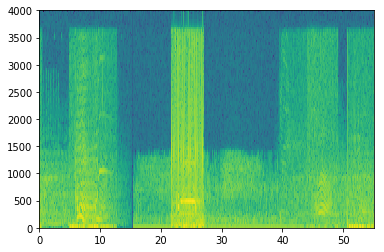

In [9]:
demo_pred = detect_calls(path_list[0], 0.5, detectionModel)
preds = np.zeros((len(path_list), 1, demo_pred.shape[1], 1))
for i, path in enumerate(path_list):
    k = detect_calls(path, 0.5, detectionModel)
    preds[i] = k

#### Get orca time in seconds
Now prediction arrays generated in previous step will be used to find the time of orca calls in seconds. 

In [10]:
chunks_call_time = []
for pred in preds:
    chunks_call_time.append(predict_call_time(pred, 0.5, 10))

#### Classification
In this step classification model is used to classify orca calls.

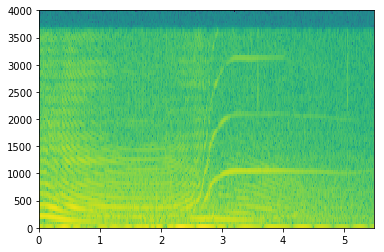

In [11]:
chunk_classes = []
for i in range(len(path_list)):
    _, aud = wavfile.read(path_list[i])
    classes = []
    for j in range(len(chunks_call_time[i])):
        start = math.floor(chunks_call_time[i][j]*44100)
        x = aud[start:start+44100]
        dat = graph_spectrogram(x).T
        if dat.shape[0] <549:
            newDaat = np.zeros((549, 101))
            newDaat[:dat.shape[0]] = dat
            newDaat = np.reshape(newDaat, (1,newDaat.shape[0], newDaat.shape[1]))
            dat = newDaat
        else:
            dat = np.reshape(dat, (1,dat.shape[0], dat.shape[1]))
        classes.append(num_to_label[np.argmax(classificationModel.predict(dat))])
    
    chunk_classes.append(classes)

#### Save summary
This function takes a dictionary as an argument and saves it in JSON and CML format.

In [12]:
def save_summary(filename, summaryDict):
    with open(filename[:-4]+'_json_summary.json', 'w') as fp:
        json.dump(summaryDict, fp)
    dom = parseString(dicttoxml.dicttoxml(summaryDict))
    with open(filename[:-4]+'_xml_summary.xml', 'w') as fp:
        fp.write(dom.toprettyxml())

#### Summarizer

`summaryDict` will contain the summary of the information extracted by our pipeline. Summary will be saved in JSON and XML format.

In [13]:
def summarizer(filename, length, channels, totalChunks, chunkLength, path_list, chunks_call_time, chunk_classes):
    summaryDict = OrderedDict()
    summaryDict = {
        "Filename": filename,
        "Length": str(length)+"sec.",
        "Channels": str(channels),
        "TotalChunks": str(totalChunks),
        "ChunkLength": str(chunkLength)+"sec."
    }
    chunkSummary = OrderedDict()
    for i in range(len(path_list)):
        chunkSummary[path_list[i][len(target_location):]] = {
            "Time": str(chunks_call_time[i]),
            "Class": str(chunk_classes[i])
        }
    
    summaryDict["ChunkData"] = dict(chunkSummary)
    summaryDict = dict(summaryDict)
    save_summary(filename, summaryDict)

In [14]:
summarizer(filename, length, channels, totalChunks, chunkLength, path_list, chunks_call_time, chunk_classes)